In [3]:
%matplotlib inline

import numpy as np# libreria para el manejo de matrices y vectores
import matplotlib.pyplot as plt #para graficar
import math #librería matemática
import cv2  #Manejo de imagenes usando opencv
#para que funcione conda install opencv
#from PIL import Image #libreria para bel manejo de imagenes tambien conocida como Pillow
#pip install pillow o conda install pillow
#anaconda en el ambiente root lo trae preparado
import time# desde la raiz importamos la libreria
import datetime
#from tensorflow.keras.models import load_model
#para instalar en anaconda tensorflow, las ultimas versiones vienen con el paquete sólo hay que habilitarlo en el ambiente
import os
print(datetime.datetime.now())

2018-11-07 00:16:59.098595


In [4]:
#funciones globales
def read_image(path):
    imagen = cv2.imread(path)#path es la dirección absoluta o relativa según el sistema operativo
    #imread carga la imagen en formato vector
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)#convierte en escala de grises la foto.
    #utiliza algo similar al algoritmo de Cammy
    return imagen

def plot_image(image, title=''):
    fig = plt.figure(figsize = (8,8))#crea una figura, vector, 8,8
 #   print(fig.shape)
    ax1 = fig.add_subplot(111)#crea una seccion de 1,1,1 en el plot
    ax1.set_xticks([])#fijar las coordenadas del plot en 0.0
    ax1.set_yticks([])

    ax1.set_title(title)#fija en vacio el titulo del plot si no viene con parámetro
    ax1.imshow(image)#muestra la imagen
    
def get_faces(image):
    # la idea es recorrer la imagen encontrar patrones e identificar cuando y donde hay una cara
    image_copy = np.copy(image)
    
    #vector con la escala de grises de la imagen
    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    #al existir un preentrenado modelo en un xml simplemente lo carga
    face_classifier = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
    
    # Detect the faces in image
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)#busca en gray los patrones que están en face_classifier
    
    return faces #regresa un arreglo de caras

def draw_faces(image, faces=None, plot=True):
    if faces is None:
        faces = get_faces(image)# en caso que no haya sido procesada la imagen se buscan las caras nuevamente
    
    image_with_faces = np.copy(image)
    
    for (x,y,w,h) in faces:
        #tupla con cuatro coordenadas en el plano cartesiano
        cv2.rectangle(image_with_faces, (x,y), (x+w,y+h), (255,0,0), 3)#dibuja un cuadrado rojo desde el punto x,y
        
    if plot is True:
        plot_image(image_with_faces)
    else:
        return image_with_faces

def plot_image_with_keypoints(image, image_info):
   
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    
    for (face, keypoints) in image_info:#busca la informacion en un diccionario y la pone en la foto
        for (x,y) in keypoints:
            ax1.scatter(x, y, marker='o', c='c', s=10)
   

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)
    # este metodo hay que probarlo bien


In [ ]:
#para probar hasta aqui


1.jpg
Faces detected: 4
2.jpg
Faces detected: 5
3.jpg
Faces detected: 4
4.jpg
Faces detected: 3
5.jpg
Faces detected: 1


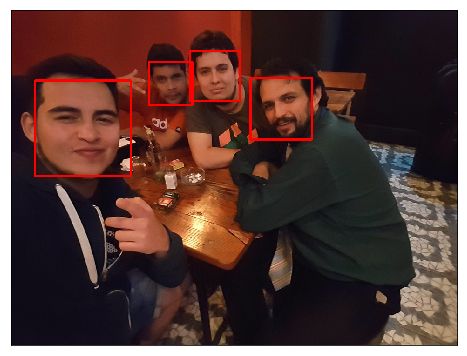

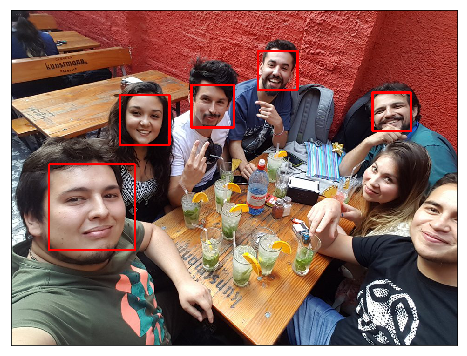

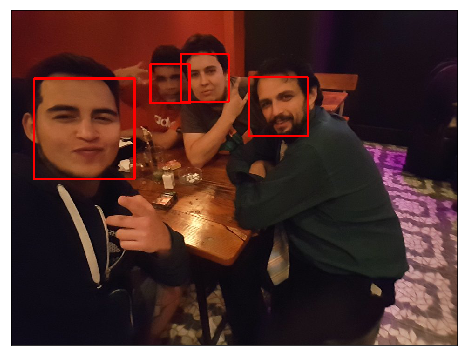

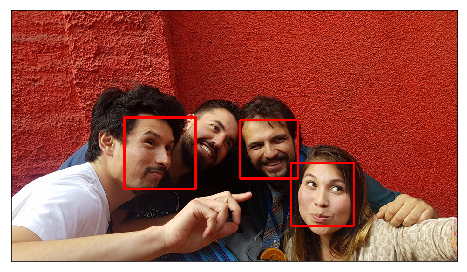

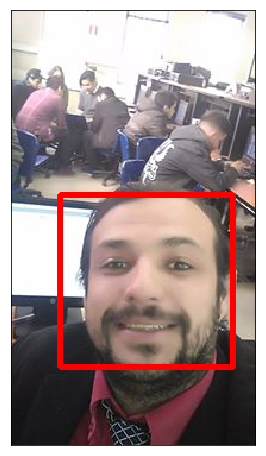

In [15]:

#Variable para la ruta al directorio
path = './DataEntrada/'
 
#Lista vacia para incluir los ficheros
lstFiles = []
 
#Lista con todos los ficheros del directorio:
lstDir = os.walk(path)   #os.walk()Lista directorios y ficheros
 
#Crea una lista de los ficheros jpg que existen en el directorio y los incluye a la lista.
 
for root, dirs, files in lstDir:
    for fichero in files:
        (nombreFichero, extension) = os.path.splitext(fichero)
        if(extension == ".jpg"):
            lstFiles.append(nombreFichero+extension)
            actual=nombreFichero+".jpg"
            print(actual)
            image = read_image(actual)
            faces = get_faces(image)
            print("Faces detected: {}".format(len(faces)))
            draw_faces(image, faces)
            i=0
            for(x,y,w,h) in faces:
                crop_img = image[y:y+h, x:x+w]
               # cv2.imshow("cropped", crop_img)
                i=i+1
                salida="entrenar/"+nombreFichero+str(i)+".jpg"
                cv2.imwrite(salida,crop_img)
                cv2.waitKey(0)

In [7]:
#entrenamiento
from PIL import Image
import os
# Path for face image database
path = 'entrenar'
recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier("detectors/haarcascade_frontalface_default.xml");
# function to get the images and label data
def getImagesAndLabels(path):
    imagePaths = [os.path.join(path,f) for f in os.listdir(path)]     
    faceSamples=[]
    ids = []
    for imagePath in imagePaths:
        PIL_img = Image.open(imagePath).convert('L') # convert it to grayscale
        img_numpy = np.array(PIL_img,'uint8')
        id = int(os.path.split(imagePath)[-1].split(".")[1])
        faces = detector.detectMultiScale(img_numpy)
        for (x,y,w,h) in faces:
            faceSamples.append(img_numpy[y:y+h,x:x+w])
            ids.append(id)
    return faceSamples,ids
print ("\n [INFO] Training faces. It will take a few seconds. Wait ...")
faces,ids = getImagesAndLabels(path)
recognizer.train(faces, np.array(ids))
# Save the model into trainer/trainer.yml
recognizer.write('trainer.yml') # recognizer.save() worked on Mac, but not on Pi
# Print the numer of faces trained and end program
print("\n [INFO] {0} faces trained. Exiting Program".format(len(np.unique(ids))))


 [INFO] Training faces. It will take a few seconds. Wait ...

 [INFO] 16 faces trained. Exiting Program



 [INFO] Exiting Program and cleanup stuff


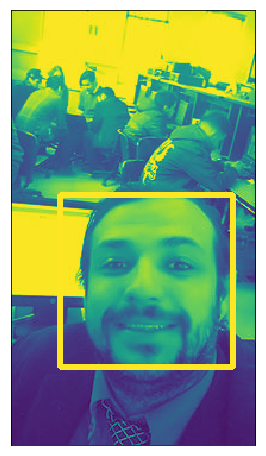

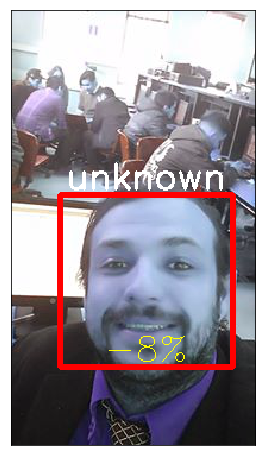

In [9]:
#reconocer
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('trainer.yml')
cascadePath = "detectors/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath);
font = cv2.FONT_HERSHEY_SIMPLEX
#iniciate id counter
id = 0
# names related to ids: example ==> Marcelo: id=1,  etc
names = ['None', 'Billy', 'Micky', 'Conyta', 'Cristobal', 'Camilo','Cristopher','Olgin','Lobo','Valverde','Reveco','Conie','Coteshita','Karen','Cata','Karen Son','Seba'] 
# Initialize and start realtime video capture
img =cv2.imread("5.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray,scaleFactor = 1.2,minNeighbors = 5)
draw_faces(gray,faces)
for(x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
    id, confidence = recognizer.predict(gray[y:y+h,x:x+w])
    # Check if confidence is less them 100 ==> "0" is perfect match 
    if (confidence < 100):
        id = names[id]
        confidence = "  {0}%".format(round(100 - confidence))
    else:
        id = "unknown"
        confidence = "  {0}%".format(round(100 - confidence))

    cv2.putText(img, str(id), (x+5,y-5), font, 1, (255,255,255), 2)
    cv2.putText(img, str(confidence), (x+5,y+h-5), font, 1, (255,255,0), 1)  

draw_faces(img,faces)
print("\n [INFO] Exiting Program and cleanup stuff")
